In [147]:
%matplotlib inline
import skimage
import h5py
import numpy as np
from skimage.transform import warp
import matplotlib.pyplot as plt
import torch

In [103]:
def valid_pixel(pixel, img_size):
    """Returns true if the pixel co-ordinate lies inside the image grid"""
    size_x, size_y = img_size
    valid = (((pixel[0] > -1) and (pixel[0] < size_x)) and
             ((pixel[1] > -1) and (pixel[1] < size_y)))
    return valid

def fw_warp_image(
    ref_view, disparity_map, ref_pos, novel_pos, 
    dtype=np.uint8, blank=0):
    """
    Returns a forward warped novel from an input image and disparity_map
    For each pixel position in the reference view, shift it by the disparity,
    and assign the value in the reference at that new pixel position to the
    novel view.

    Keyword arguments:
    ref_view -- colour image data at the reference position
    disparity_map -- a disparity map at the reference position
    ref_pos -- the grid co-ordinates of the ref_view
    novel_pos -- the target grid position for the novel view
    """
    size_x, size_y = ref_view.shape[0:2]
    distance = ref_pos - novel_pos

    #Initialise an array of blanks
    novel_view = np.full(ref_view.shape, blank, dtype=dtype)

    #Create an array of pixel positions
    grid = np.meshgrid(np.arange(size_x), np.arange(size_y), indexing='ij')
    stacked = np.stack(grid, 2)
    pixels = stacked.reshape(-1, 2)

    #Repeat the elements of the disparity_map to match the distance
    repeated = np.repeat(disparity_map, 2, -1).reshape((size_x * size_y, 2))

    #Round to the nearest integer value
    result = (repeated * distance).astype(int)
    novel_pixels = pixels + result
    
    #Move the pixels from the reference view to the novel view
    for novel_coord, ref_coord in zip(novel_pixels, pixels):
        if valid_pixel(novel_coord, ref_view.shape[0:2]):
            novel_view[novel_coord[0], novel_coord[1]] = (
                ref_view[ref_coord[0], ref_coord[1]])

    return novel_view

In [124]:
def shift_up10_left20(xy):
    return xy - np.array([-20, 10])[None, :]

def shift_disp(xy, disp, distance, dtype):
    #Repeat the elements of the disparity_map to match the distance
    size_x, size_y = disp.shape[0:2]
    print(disp.shape)
    print(disp.T.shape)
    repeated = np.repeat(disp.T, 2, -1).reshape((size_x * size_y, 2))

    #Round to the nearest integer value
    result = (repeated * distance).astype(dtype)
    return xy - result

def sk_warp(
    ref_view, disparity_map, ref_pos, novel_pos, 
    dtype=np.float32, blank=0, preserve_range=False):
    """
    Uses skimage to perform backward warping:
    
    Keyword arguments:
    ref_view -- colour image data at the reference position
    disparity_map -- a disparity map at the reference position
    ref_pos -- the grid co-ordinates of the ref_view
    novel_pos -- the target grid position for the novel view
    dtype -- data type to consider disparity as
    blank -- value to use at positions not seen in reference view
    preserve_range -- Keep the data in range 0, 255 or convert to 0 1
    """
    size_x, size_y = ref_view.shape[0:2]
    distance = ref_pos - novel_pos
    
    novel_view = warp(
        image=ref_view, inverse_map=shift_disp, 
        map_args={"disp": disparity_map, "distance": np.flipud(distance), "dtype": dtype},
        cval=blank, preserve_range=preserve_range
        )
    if preserve_range:
        novel_view = novel_view.astype(np.uint8)
    return novel_view

In [268]:
def torch_sample(array, indexes, desired_shape):
    """
    From a numpy array, and a set of indices of shape [2, X]
    Where indexes[0] denotes the x indices of the array
    and indexes[1] denotes the y indices of the array
    return array indexed at these positions
    """
    torch_arr = torch.tensor(array, dtype=torch.float64)
    indexed = torch_arr[[indexes[0], indexes[1]]]
    return indexed.reshape(desired_shape[0], desired_shape[1], desired_shape[2])

def torch_warp(
        ref_view, disparity_map, ref_pos, novel_pos):
    s_indices = np.arange(ref_view.shape[0])
    t_indices = np.arange(ref_view.shape[0])
    
    x, y = np.meshgrid(s_indices, t_indices, indexing= 'ij')
    
    distance = ref_pos - novel_pos
    
    x_shifted = (x.astype(np.float32) - disparity_map * distance[0]).flatten()
    y_shifted = (y.astype(np.float32) - disparity_map * distance[1]).flatten()
    
    #indices for linear interpolation in a square around the central point
    x_low = np.floor(x_shifted).astype(int)
    x_high = x_low + 1
    
    y_low = np.floor(y_shifted).astype(int)
    y_high = y_low + 1
    
    #Place co-ordinates outside the image back into the image
    x_low_clip = np.clip(x_low, 0, ref_view.shape[0] - 1)
    x_high_clip = np.clip(x_high, 0, ref_view.shape[0] - 1)
    y_low_clip = np.clip(y_low, 0, ref_view.shape[1] - 1)
    y_high_clip = np.clip(y_high, 0, ref_view.shape[1] - 1)
    
    #Gather the interpolation points
    interp_pts_1 = np.stack((x_low_clip, y_low_clip), -1).T
    interp_pts_2 = np.stack((x_low_clip, y_high_clip), -1).T
    interp_pts_3 = np.stack((x_high_clip, y_low_clip), -1).T
    interp_pts_4 = np.stack((x_high_clip, y_high_clip), -1).T
    
    #Index into the images
    desired_shape = ref_view.shape
    res_1 = torch_sample(ref_view, interp_pts_1, desired_shape)
    res_2 = torch_sample(ref_view, interp_pts_2, desired_shape)
    res_3 = torch_sample(ref_view, interp_pts_3, desired_shape)
    res_4 = torch_sample(ref_view, interp_pts_4, desired_shape)
 
    #Compute interpolation weights
    x_low_f = x_low.astype(np.float64)
    d_x_low = 1.0 - (x_shifted - x_low_f)
    d_x_high = 1.0 - d_x_low
    y_low_f = y_low.astype(np.float64)
    d_y_low = 1.0 - (y_shifted - y_low_f)
    d_y_high = 1.0 - d_y_low
    
    w1 = torch.from_numpy(d_x_low * d_y_low)
    w2 = torch.from_numpy(d_x_low * d_y_high)
    w3 = torch.from_numpy(d_x_high * d_y_low)
    w4 = torch.from_numpy(d_x_high * d_y_high)
    
    weighted_1 = torch.mul(w1.repeat(3).reshape(desired_shape), res_1)
    weighted_2 = torch.mul(w2.repeat(3).reshape(desired_shape), res_2)
    weighted_3 = torch.mul(w3.repeat(3).reshape(desired_shape), res_3)
    weighted_4 = torch.mul(w4.repeat(3).reshape(desired_shape), res_4)
    
    novel_view = torch.add(torch.add(weighted_1, weighted_2), weighted_3)
    torch.add(novel_view, weighted_4, out=novel_view)
    return novel_view

skimage.transform.warp(image, inverse_map, map_args={}, output_shape=None, order=1, mode='constant', cval=0.0, clip=True, preserve_range=False)
See http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.warp

In [132]:
print(np.array([-20, 10])[None])
print(np.flipud(np.array([1, 2]).T))
x = np.array([1, 2.3, 2.8])
print(x.astype(np.uint8))
print(np.around(x, 0).astype(np.uint8))

[[-20  10]]
[2 1]
[1 2 2]
[1 2 3]


(512, 512)
(512, 512)
CPU times: user 72 ms, sys: 0 ns, total: 72 ms
Wall time: 67.9 ms
CPU times: user 524 ms, sys: 16 ms, total: 540 ms
Wall time: 514 ms
CPU times: user 120 ms, sys: 0 ns, total: 120 ms
Wall time: 36.4 ms


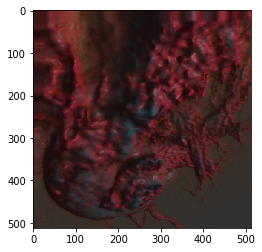

In [269]:
file_path = "/users/pgrad/martins7/turing/overflow-storage/numpy_set/small_set.h5"
sample_index = 10
with h5py.File(file_path, mode='r', libver='latest', swmr=True) as h5_file:
    col = h5_file['train']['colour']['images'][sample_index] 
    disp = h5_file['train']['disparity']['images'][sample_index]
    grid_size = 64
    grid_one_way = 8
    sample_index = grid_size // 2 + (grid_one_way // 2)
    """
    shape = col.shape[1:3]
    rows, cols = shape[0], shape[1]
    tf_coords = np.indices((cols, rows), np.float32).reshape(2, -1).T
    print(tf_coords)
    #print(sample_index)
    #print(shift_disp(tf_coords, disp[sample_index], 3))
    """
    %time sk_warp(col[sample_index], disp[sample_index, :, :, 0], np.asarray((4, 4)), np.asarray((0, 0)))
    %time fw_warp_image(col[sample_index], disp[sample_index, :, :, 0], np.asarray((4, 4)), np.asarray((0, 0)))
    #res = sk_warp(col[sample_index], disp[sample_index, :, :, 0], np.asarray((4, 4)), np.asarray((3, 0)))
    #plt.imshow(col[sample_index])
    #print(res)
    #plt.imshow(res)
    %time torch_warp(col[sample_index], disp[sample_index, :, :, 0], np.asarray((4, 4.0)), np.asarray((0.0, 0.0)))
    res = torch_warp(col[sample_index], disp[sample_index, :, :, 0], np.asarray((4.0, 4.0)), np.asarray((0.0, 0.0)))
    plt.imshow(np.around(res.numpy()).astype(np.uint8))